# Results analysis

#### dataset Loading and options 

In [38]:
from datasets import (
    Dataset,
    load_dataset,
    concatenate_datasets,
    get_dataset_config_names,
)
import pandas as pd
import seaborn as sb

all_configs = [
    config_name
    for config_name in get_dataset_config_names("CharlyR/varbench-evaluation")
    if "benchmark" in config_name
]
print(all_configs)

#TODO remove this line 
all_configs = ["simpleLLM_test_llama3.18binstant_pk_3_t_0.7"]

all_datasets: list[Dataset] = []

for config in all_configs:
    conf_ds = load_dataset("CharlyR/varbench-evaluation", config, split="tikz")
    config_name_column = ["".join(config.split("_benchmark"))] * len(conf_ds)
    all_datasets.append(conf_ds.add_column("config", config_name_column))


dataset = concatenate_datasets(all_datasets)

import os

result_path = os.path.join("results", "all_results")
not os.path.exists("results/all_results") and os.mkdir("results/" + "all_results")

['simpleLLM_benchmark_deepseekr1distillllama70b_pk_1_t_0.7', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_0.7', 'simpleLLM_benchmark_deepseekr1distillllama70b_pk_5_t_1.5', 'simpleLLM_benchmark_llama3.18binstant_pk_1_t_0.7', 'simpleLLM_benchmark_llama3.370bversatile_pk_1_t_0.7', 'simpleLLM_benchmark_llama370b8192_pk_1_t_0.7', 'simpleLLM_benchmark_mixtral8x7b32768_pk_1_t_0.7']


Generating tikz split: 100%|██████████| 2/2 [00:00<00:00, 574.05 examples/s]


False

## Variants Overall Validity

In [3]:
df  = dataset.to_pandas()[["config","id","parsing_score","compiling_score"]]

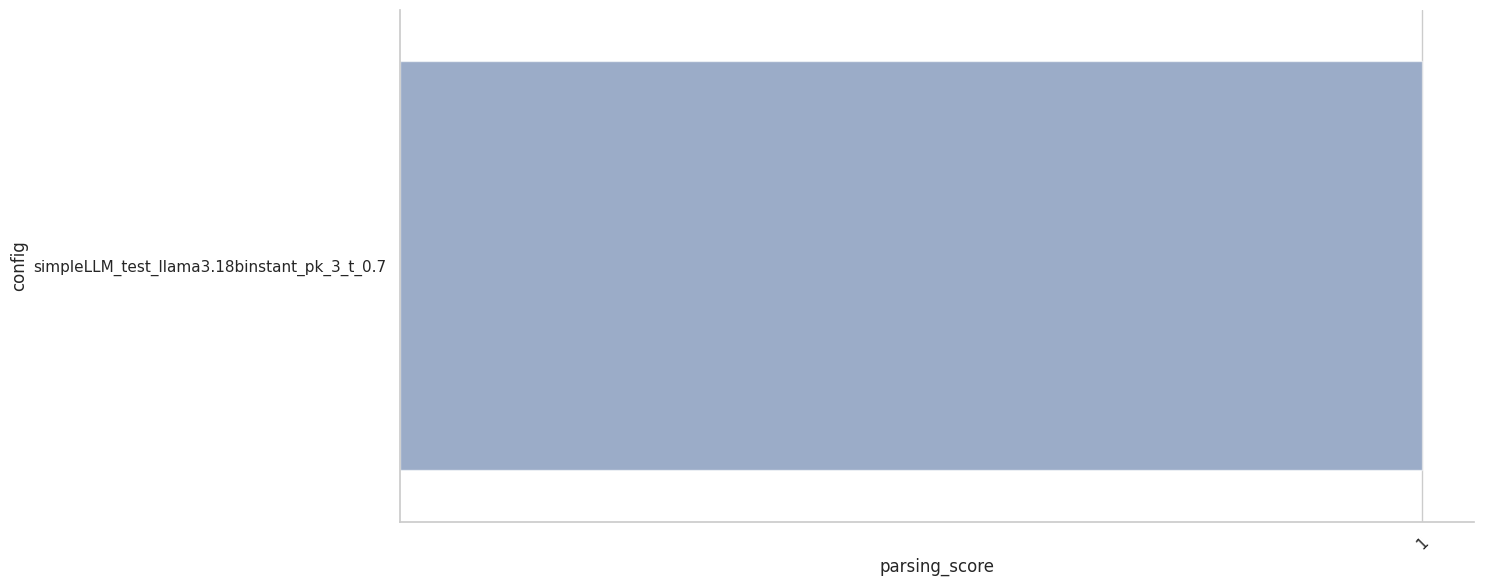

In [4]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="parsing_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["parsing_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

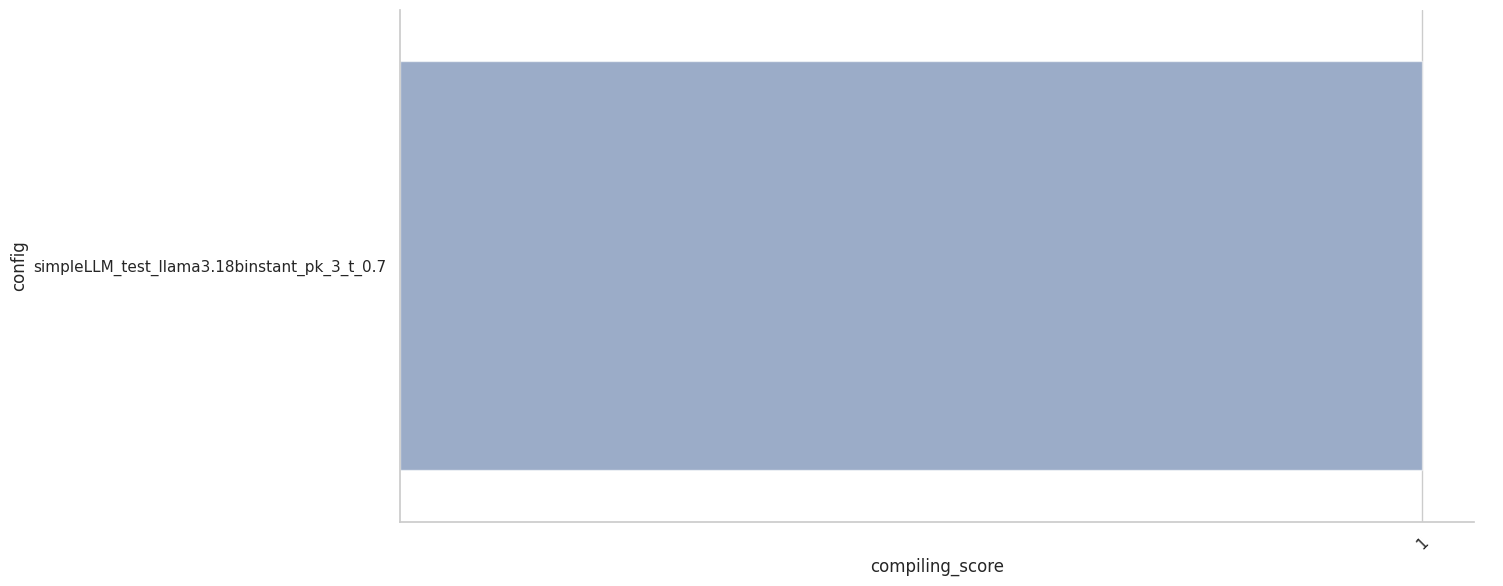

In [5]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="compiling_score", y="config",
    alpha=.6, height=6, aspect=2.5
)

# Adjust x-axis granularity
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(df["compiling_score"].min(), 1.01, step=0.1))  # Adjust step size

plt.show()

## Best prediction computation

---

In [52]:
from results_utils import MetricPolicy
import pandas as pd

computed_metrics_names = [
    metric_name
    for metric_name in dataset.column_names
    if metric_name.endswith("Metric")
]

# TODO Update with metric_analysis output
most_important_metrics = ["TemplateMetric", "ImageEqualityMetric", "LineMetric", "CrystalBleuPatchMetric"]
metric_priority_order = most_important_metrics + (
    list(set(computed_metrics_names) - set(most_important_metrics))
)

print(
    computed_metrics_names
    + ["patch", "template_solution_code", "code_solution", "difficulty_ast"]
)

result_df: pd.DataFrame = dataset.to_pandas().explode(
    computed_metrics_names
    + ["patch", "template_solution_code", "code_solution", "difficulty_ast"]
)

result_df[computed_metrics_names + ["images_result", "predictions", "predictions_patches"]]

['LineMetric', 'ImageEqualityMetric', 'TemplateMetric', 'CrystalBleuPatchMetric', 'patch', 'template_solution_code', 'code_solution', 'difficulty_ast']


,LineMetric,ImageEqualityMetric,TemplateMetric,CrystalBleuPatchMetric,images_result,predictions,predictions_patches
0,"[100.0, 100.0, 100.0]","[0.0, 0.0, 0.0]","[100.0, 100.0, 100.0]","[82.32074, 82.32074, 82.32074]",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,"[\documentclass[tikz,border=5]{standalone}\n\u...","[@@ -22,2 +22,2 @@\n\n-on left= {colors alias=..."
1,"[100.0, 100.0, 100.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[92.51563, 92.51563, 92.51563]",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,"[\documentclass[tikz,border=5]{standalone}\n\u...",[@@ -24 +24 @@\n\n-lower wing/.style={fill=Blu...
1,"[100.0, 100.0, 100.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[92.51563, 92.51563, 92.51563]",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...,"[\documentclass[tikz,border=5]{standalone}\n\u...",[@@ -24 +24 @@\n\n-lower wing/.style={fill=Blu...


TODO: simply explode twice into groupby id

In [ ]:

#passk priotiry
print(computed_metrics_names + ["images_result", "predictions", "predictions_patches"])

result_df: pd.DataFrame = result_df.explode(
    computed_metrics_names + ["images_result", "predictions", "predictions_patches"]
)
df_sorted = result_df.sort_values(by=metric_priority_order, ascending=False)
df_sorted

# Get the highest row per group based on sorting order
result = df_sorted.groupby(["id", "config"]).first().reset_index()


result_df = result[computed_metrics_names + ["id", "config","difficulty"]].astype({m_name:'float' for m_name in computed_metrics_names})
result_df

##### debug

In [44]:
tmp = result_df[result_df["id"]=="bee_red_stripes"][["patch","predictions_patches","TemplateMetric"]]
print(tmp.iloc[0]["predictions_patches"][2])

@@ -22,2 +22,2 @@

-on left= {colors alias={body as BlueGrey800, stripes as Amber500}},
-on right={colors alias={body as BlueGrey900, stripes as Amber700}, half clip},
+on left= {colors alias={body as BlueGrey800, stripes as Red800}},
+on right={colors alias={body as BlueGrey900, stripes as Red900}, half clip},


In [41]:
print(tmp.iloc[0]["patch"])

@@ -22,2 +22,2 @@

-on left= {colors alias={body as BlueGrey800, stripes as Amber500}},
-on right={colors alias={body as BlueGrey900, stripes as Amber700}, half clip},
+on left= {colors alias={body as BlueGrey800, stripes as Red500}},
+on right={colors alias={body as BlueGrey900, stripes as Red700}, half clip},


In [42]:
print(tmp.iloc[0]["TemplateMetric"])

[100. 100. 100.]


## Pre-Filtering

In [ ]:
# ordering by text metrics IGNORED
""" text_metrics = [
    metric_name
    for metric_name in computed_metrics_names
    if any((substring in metric_name) for substring in ["TER", "Line", "Bleu", "Chrf","Patch"])
]
other_metrics = list(set(computed_metrics_names) - set(text_metrics))
ordered_metrics = [metric for metric in (text_metrics + other_metrics)]
print(text_metrics + other_metrics) """
#Ordering by priority metrics
filtered_df = result_df[metric_priority_order+ ["id", "config","difficulty"]]
#filtered_df["LineMetric"] = filtered_df["LineMetric"].fillna(0)
#filtered_df["PatchMetric"] = filtered_df["PatchMetric"].fillna(0)

In [ ]:
filtered_df[filtered_df.isnull().any(axis=1)]

,PatchMetric,LineMetric,LPIPSMetric,TERMetric,ClipTextMetric,MSEMetric,TERPatchMetric,PSNRMetric,ChrfMetric,BleuMetric,ChrfPatchMetric,BleuPatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,MSSSIMMetric,ClipImageMetric,FeatureMatchMetric,id,config,difficulty
5,0.0,100.000000,NaN,87.062935,NaN,NaN,50.000000,NaN,96.195602,90.586449,43.581493,3.476955e+00,2.907535e+00,88.457794,NaN,NaN,NaN,bee_eyes,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,hard
6,0.0,100.000000,NaN,93.258430,NaN,NaN,50.000000,NaN,96.457451,93.464706,43.613686,1.191081e+01,1.069608e+01,91.256622,NaN,NaN,NaN,bee_eyes,simpleLLM_llama3.18binstant_pk_1_t_0.7,hard
7,0.0,100.000000,NaN,93.609024,NaN,NaN,50.000000,NaN,97.331070,93.854279,50.257553,4.708044e+00,4.288280e+00,92.455261,NaN,NaN,NaN,bee_eyes,simpleLLM_llama3.370bversatile_pk_1_t_0.7,hard
8,0.0,0.000000,NaN,95.769234,NaN,NaN,56.666668,NaN,97.216331,96.374313,41.916721,5.431949e+00,4.083445e+00,95.516396,NaN,NaN,NaN,bee_eyes,simpleLLM_llama370b8192_pk_1_t_0.7,hard
27,0.0,100.000000,NaN,96.774193,NaN,NaN,78.431374,NaN,98.905998,97.882851,91.089577,7.048371e+01,7.280450e+01,97.389420,NaN,NaN,NaN,bee_three_wings,simpleLLM_llama3.370bversatile_pk_1_t_0.7,medium
29,0.0,50.000000,NaN,98.765434,NaN,NaN,75.471695,NaN,98.379059,98.578224,43.420559,2.552825e+01,2.552825e+01,98.578224,NaN,NaN,NaN,bee_three_wings,simpleLLM_mixtral8x7b32768_pk_1_t_0.7,medium
32,0.0,0.000000,NaN,76.704544,NaN,NaN,50.000000,NaN,96.723503,83.415237,26.052944,3.612566e+00,3.593148e+00,83.230034,NaN,NaN,NaN,boson_square,simpleLLM_llama3.370bversatile_pk_1_t_0.7,easy
33,0.0,0.000000,NaN,90.401787,NaN,NaN,50.000000,NaN,97.236374,93.159981,27.238331,2.666240e+00,2.716563e+00,92.409775,NaN,NaN,NaN,boson_square,simpleLLM_llama370b8192_pk_1_t_0.7,easy
36,0.0,0.000000,NaN,64.507774,NaN,NaN,50.000000,NaN,95.354309,80.509499,25.841228,5.929861e+00,5.580572e+00,79.938988,NaN,NaN,NaN,box_other_measure,simpleLLM_llama3.18binstant_pk_1_t_0.7,easy
91,0.0,0.000000,NaN,87.782806,NaN,NaN,53.191490,NaN,93.635025,91.038689,18.673082,2.018780e+00,1.995604e+00,89.896706,NaN,NaN,NaN,chimpanzee_shoulder_torso,simpleLLM_llama3.18binstant_pk_1_t_0.7,hard


## Passing rate

In [9]:
def compute_pass(row):
    row["pass"] = (not row.isnull().any())*100
    return row
pass_dataset = filtered_df[computed_metrics_names+["difficulty","id","config"]].apply(compute_pass,axis=1)


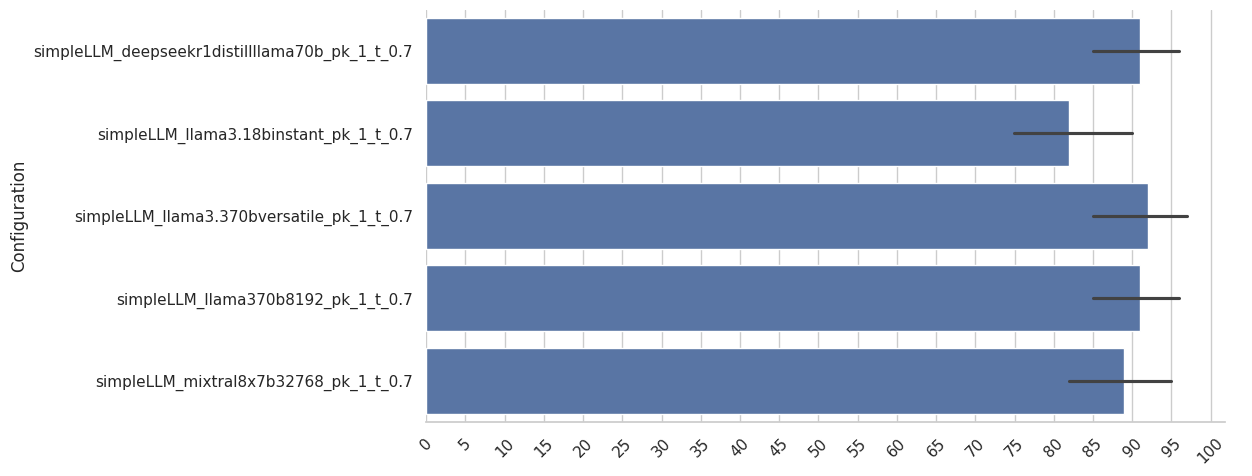

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=pass_dataset, kind="bar", x="pass",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object
ax.set_xticks(np.arange(0, 100.01, step=5))  # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Configuration")
g.legend.set_title("")
plt.savefig(os.path.join(result_path,"pass_rate.png"), dpi=300, bbox_inches="tight")

plt.show()



## Exact patch

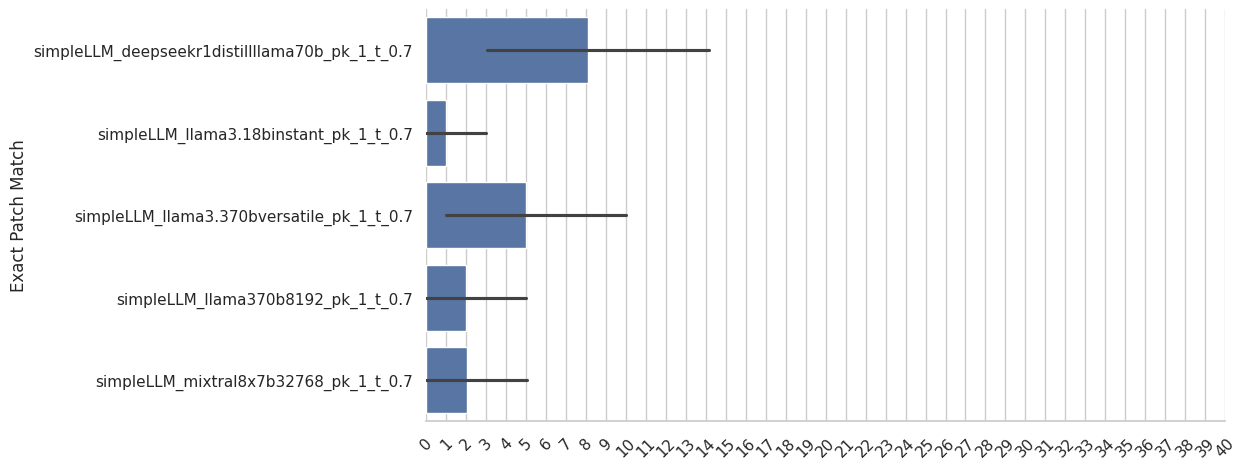

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="PatchMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["PatchMetric"].mean()+filtered_df["PatchMetric"].std()*2, 1)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Exact Patch Match")
g.legend.set_title("")
plt.savefig(os.path.join(result_path,"same_patch_measures.png"), dpi=300, bbox_inches="tight")

plt.show()


In [33]:
filtered_df[
    filtered_df["config"].str.contains("370b") &
    (filtered_df["PatchMetric"] != 0) &
    (filtered_df["PatchMetric"] != 100)
]["PatchMetric"]


Series([], Name: PatchMetric, dtype: float64)

## Right lines

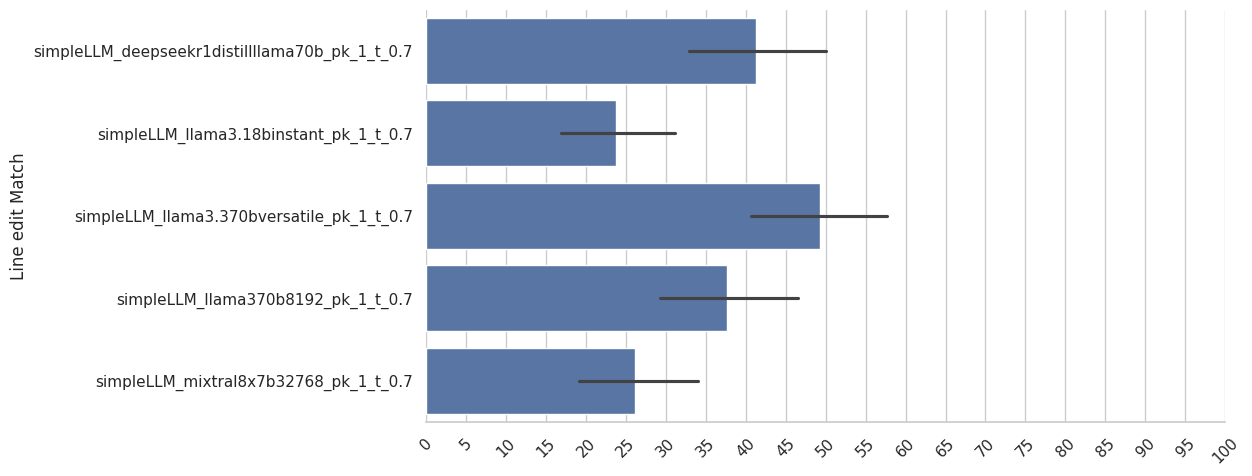

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=filtered_df, kind="bar", x="LineMetric",y="config", aspect=2.5
)
plt.xticks(rotation=45)  # Rotate labels if needed
ax = g.ax  # Get the axis object

ax.set_xticks(np.arange(0.0, filtered_df["LineMetric"].max()+1, 5)) # Adjust step size
g.despine(left=True)
g.set_axis_labels("", "Line edit Match")
g.legend.set_title("")

plt.savefig(os.path.join(result_path,"irght_lines_measures.png"), dpi=300, bbox_inches="tight")
plt.show()


## variant classification

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd

def plot_nested_circles_subplot(classed_dataset: pd.DataFrame):
    """
    Generates subplots of nested circle diagrams for each configuration in the dataset.
    Uses a blue gradient color scheme and places values slightly below the top of each circle.
    Only one shared legend is created for the entire plot.
    """
    sns.set()
    
    configs = classed_dataset["config"].unique()
    num_configs = len(configs)
    
    # Calculate the number of rows needed, with a maximum of 3 subplots per row
    ncols = 3
    nrows = (num_configs + ncols - 1) // ncols  # This ensures enough rows
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten()  # Flatten to easily iterate over

    legend_handles = []  # Collect all legend handles here
    
    for i, config in enumerate(configs):
        ax = axes[i]
        ax.set_aspect('equal')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

        cols = classed_dataset.columns.to_list()
        cols.remove("config")
        classes = classed_dataset[classed_dataset["config"] == config][cols].iloc[0].to_dict()
        
        max_r = max(classes.values())
        ax.set_xlim(-max_r - 1, max_r + 1)
        ax.set_ylim(-1, max_r * 2 + 1)

        n = len(classes)
        cmap = LinearSegmentedColormap.from_list('blue_gradient', ['#ADD8E6', '#00008B'], N=n)
        colors = [cmap(i) for i in np.linspace(0, 1, n)]

        sorted_classes = sorted(classes.items(), key=lambda x: x[1], reverse=True)

        for (label, r), color in zip(sorted_classes, colors):
            circle = plt.Circle((0, r), r, fill=True, facecolor=color, alpha=0.6,
                                edgecolor='black', linewidth=2)
            ax.add_patch(circle)

            # Collect the legend handles (only once for each unique color)
            if i == 0:  # Only create the legend once, for the first plot
                legend_handles.append(mpatches.Patch(color=color, label=f"{label} ({r})"))

            # Adjust text position
            ax.annotate(str(r),(0,r*2),(0,-1),ha='center', va='bottom', fontsize=12,textcoords='offset points')

        ax.set_title(f"{config}", y=1.05)

    # Hide unused subplots
    for j in range(num_configs, len(axes)):
        axes[j].axis('off')

    # Create one shared legend for the entire plot
    fig.legend(handles=legend_handles, loc='lower right', bbox_to_anchor=(1, 0), frameon=False)

    plt.tight_layout()
    plt.savefig(os.path.join(result_path, "concentric_variant_classif.png"), dpi=300, bbox_inches="tight")
    plt.show()


In [14]:
def compute_class(row):
    row["total"] = 1
    row["valid"] = not row.isnull().any()
    row["correct"] = row["ChrfPatchMetric"] > 50 and row["valid"] # arbitrary for now
    row["sound"] = row["LineMetric"] > 0 and row["correct"] 
    row["perfect"] = row["PatchMetric"] == 100 and row["sound"]
    return row


classed_dataset = filtered_df[
    computed_metrics_names + ["difficulty", "id", "config"]
].apply(compute_class, axis=1)[["difficulty", "id", "config","total","valid","correct","sound","perfect"]]
classed_dataset =classed_dataset.groupby("config").sum().reset_index()
classed_dataset

,config,difficulty,id,total,valid,correct,sound,perfect
0,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,easyhardmediumeasyeasymediumeasyeasyhardmedium...,beam_coord_changebee_eyesbee_longer_bodybee_mi...,100,91,42,34,8
1,simpleLLM_llama3.18binstant_pk_1_t_0.7,easyhardmediumeasyeasymediumeasyeasyhardmedium...,beam_coord_changebee_eyesbee_longer_bodybee_mi...,100,82,20,18,1
2,simpleLLM_llama3.370bversatile_pk_1_t_0.7,easyhardmediumeasyeasymediumeasyeasyhardmedium...,beam_coord_changebee_eyesbee_longer_bodybee_mi...,100,92,47,42,5
3,simpleLLM_llama370b8192_pk_1_t_0.7,easyhardmediumeasyeasymediumeasyeasyhardmedium...,beam_coord_changebee_eyesbee_longer_bodybee_mi...,100,91,38,33,2
4,simpleLLM_mixtral8x7b32768_pk_1_t_0.7,easyhardmediumeasyeasymediumeasyeasyhardmedium...,beam_coord_changebee_eyesbee_longer_bodybee_mi...,100,89,24,20,2


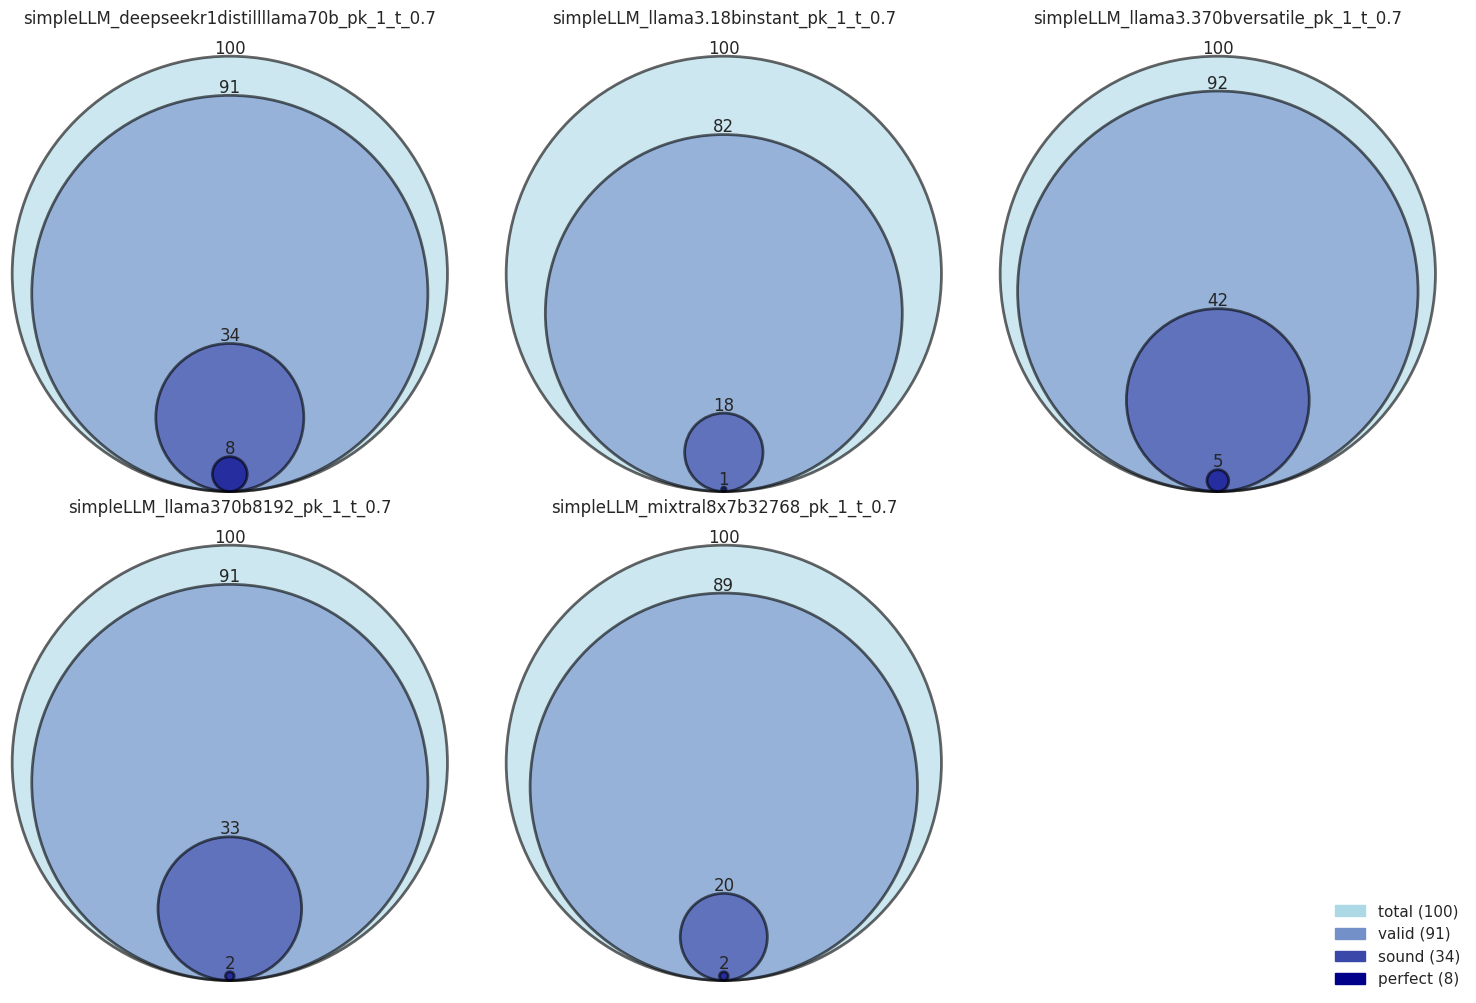

In [15]:
plot_nested_circles_subplot(classed_dataset[["config","total", "valid", "sound", "perfect"]])


## All metrics

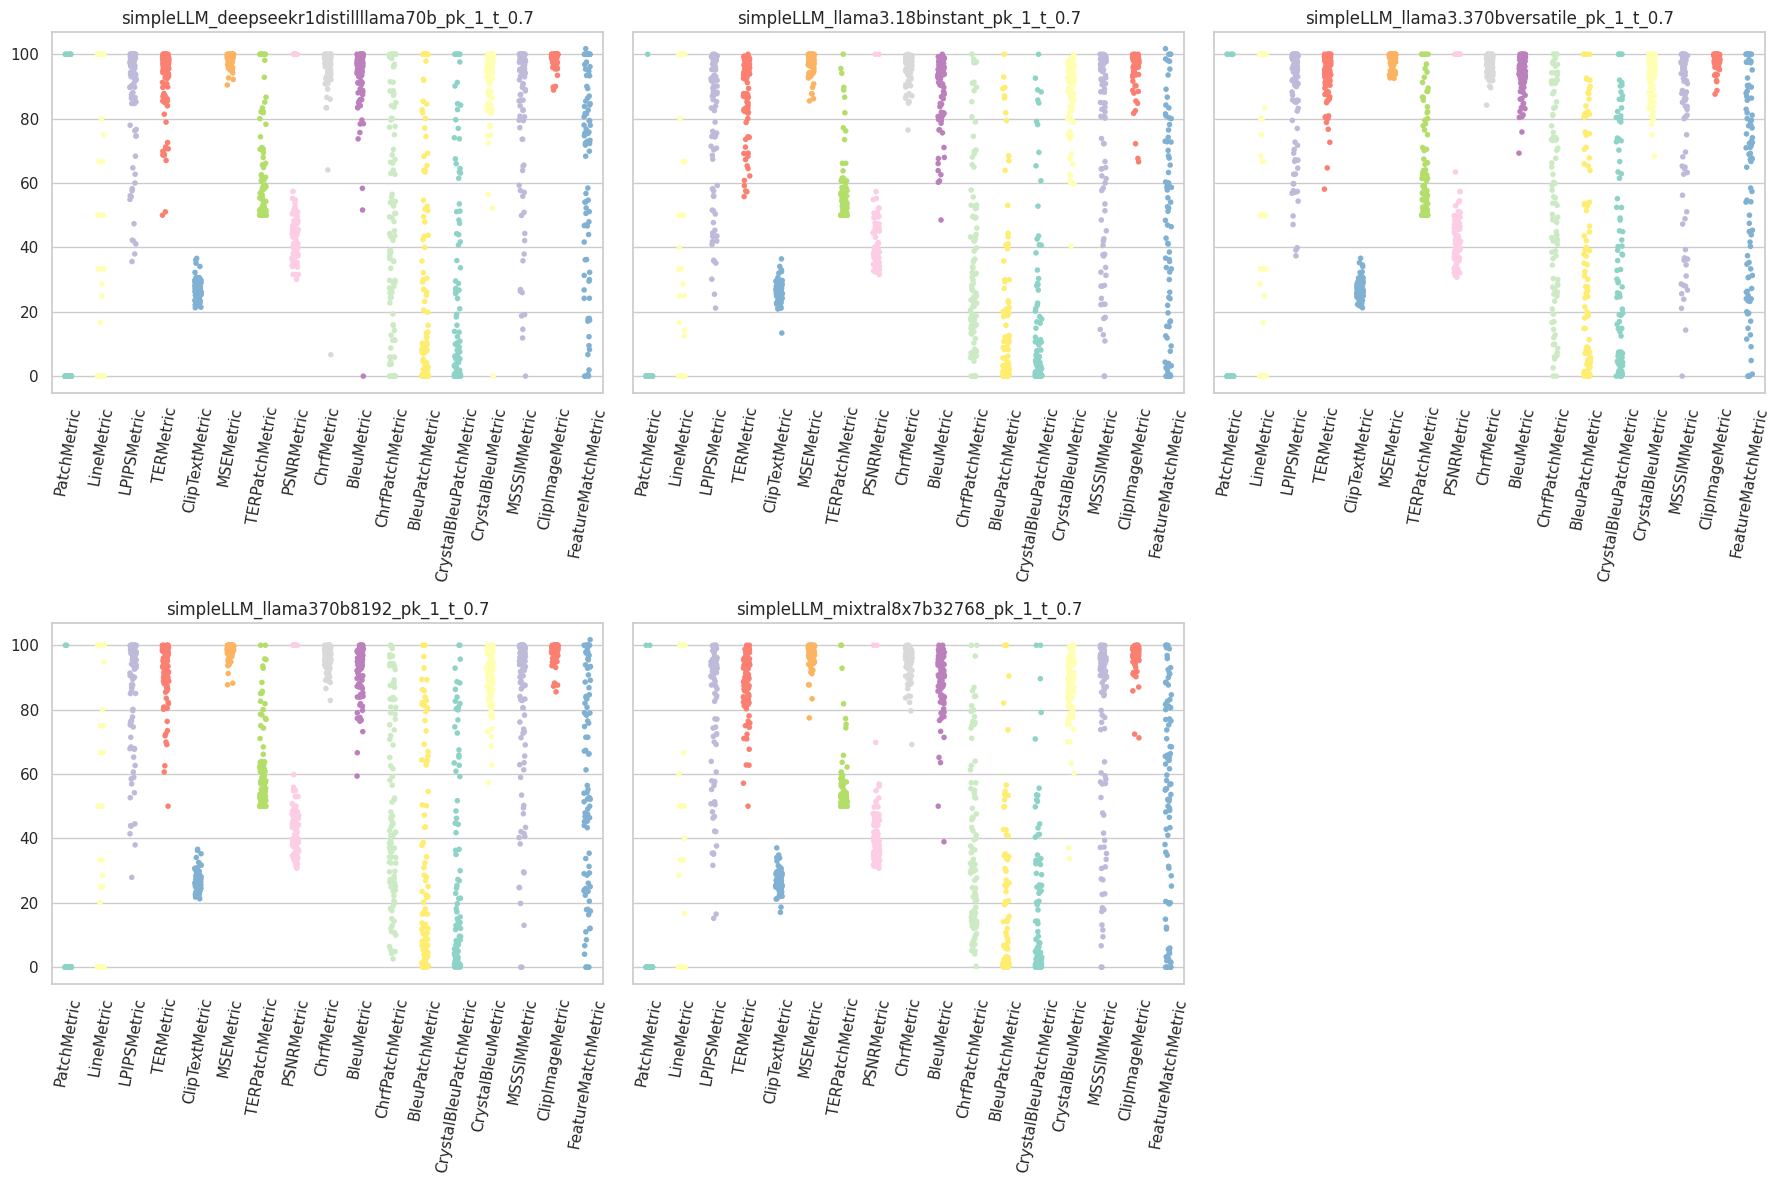

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_theme(style="whitegrid")

# Get unique configuration values
configs = filtered_df["config"].unique().tolist()

# Determine grid size
cols = 3
rows = (len(configs) // cols) + (len(configs) % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows), sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, config_name in enumerate(configs):
    sns.stripplot(
        data=filtered_df[filtered_df['config'] == config_name], 
        ax=axes[i], 
        palette="Set3",
        size=4,
        jitter=True
    )
    axes[i].set_title(f'{config_name}')
    axes[i].tick_params(axis='x', rotation=80)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(result_path, "strip_by_config.png"), dpi=300, bbox_inches="tight")
plt.show()


In [17]:
filtered_df.dtypes

PatchMetric               float64
LineMetric                float64
LPIPSMetric               float64
TERMetric                 float64
ClipTextMetric            float64
MSEMetric                 float64
TERPatchMetric            float64
PSNRMetric                float64
ChrfMetric                float64
BleuMetric                float64
ChrfPatchMetric           float64
BleuPatchMetric           float64
CrystalBleuPatchMetric    float64
CrystalBleuMetric         float64
MSSSIMMetric              float64
ClipImageMetric           float64
FeatureMatchMetric        float64
id                         object
config                     object
difficulty                 object
dtype: object

In [48]:
filtered_df["config"] = pd.Categorical(
    filtered_df["config"], categories=configs, ordered=True
)

def get_compiling_score(row):
    row["valid"] = (not row.isnull().any())*100
    return row

filtered_valid = filtered_df.apply(get_compiling_score,axis=1)

averages = (
    filtered_valid.drop(["difficulty", "id"], axis=1)
    .groupby("config", observed=True)
    .mean()
    .reset_index()
)


averages.to_csv(os.path.join(result_path, "avg_by_config.csv"))


def apply_title_reduction(row):
    row["model"] = row["config"].split("_")[1]
    row["k"] = row["config"].split("_")[3]
    row["temp."] = row["config"].split("_")[5]

    return row

averages = averages.apply(apply_title_reduction, axis=1)
averages = averages.drop("config", axis=1)
for col in averages.columns:
    averages = averages.rename(columns={col: col.removesuffix("Metric")})

averages = averages[
    ["model", "k", "temp."]
    + list(set(averages.columns.to_list()) - set(["model", "k", "temp."]))
]
averages = averages.sort_values(by="Bleu")

# averages = averages.round(1)
averages.to_latex(os.path.join(result_path, "avg_by_config.tex"), float_format="%.1f",index=False)



df_base = averages[['model', 'k', 'temp.']]

# List of metric subsets and filenames
metrics = [
    (['ChrfPatch', 'BleuPatch', 'CrystalBleuPatch', 'TERPatch'], "avg_by_config_patchtext.tex", True),
    (['LPIPS', 'MSSSIM', 'PSNR', 'ClipImage', 'ClipText', 'FeatureMatch',"MSE"], "avg_by_config_image.tex", True),
    (['Chrf', 'Bleu', 'CrystalBleu', 'TER'], "avg_by_config_full_text.tex", True),
    (['Line', 'Patch', 'valid'], "avg_by_config_patch_line.tex", True)
]

# Generate LaTeX files with resize for patch-based metrics
for cols, filename, apply_resize in metrics:
    df = df_base.join(averages[cols])
    path = os.path.join(result_path, filename)
    df.to_latex(path, float_format="%.1f", index=False)
    
    if apply_resize:  # Ensure resizebox is added correctly
        with open(path, 'r') as f:
            content = f.read()
        with open(path, 'w') as f:
            f.write(f"\\resizebox{{\\columnwidth}}{{!}}{{\n{content}\n}}")

In [19]:
filtered_df['config'] = pd.Categorical(filtered_df['config'], categories=configs, ordered=True)
averages = filtered_df.drop(["difficulty","id"],axis=1).groupby('config',observed=True).median()
averages.to_csv(os.path.join(result_path,"med_by_config.csv"))

averages

,PatchMetric,LineMetric,LPIPSMetric,TERMetric,ClipTextMetric,MSEMetric,TERPatchMetric,PSNRMetric,ChrfMetric,BleuMetric,ChrfPatchMetric,BleuPatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,MSSSIMMetric,ClipImageMetric,FeatureMatchMetric
config,,,,,,,,,,,,,,,,,
simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,0.0,20.833333,93.750412,96.888885,26.224602,99.603279,52.447552,44.606976,98.497452,96.549896,44.283436,12.194119,12.272002,95.305878,94.136856,99.347023,74.698792
simpleLLM_llama3.18binstant_pk_1_t_0.7,0.0,0.000000,86.978535,93.763233,25.914716,98.609280,52.577229,38.632332,97.691235,93.560379,28.451809,3.572168,3.209938,92.482956,80.658173,98.268120,49.820282
simpleLLM_llama3.370bversatile_pk_1_t_0.7,0.0,50.000000,94.214943,95.214039,26.588906,99.476089,56.903593,42.566906,98.046257,95.141712,53.719233,27.137763,25.735650,93.936668,91.723263,99.394516,69.074844
simpleLLM_llama370b8192_pk_1_t_0.7,0.0,0.000000,93.599953,94.114086,26.181454,99.497833,54.633034,42.081120,97.710514,93.898060,41.866653,13.488061,13.296630,92.734169,90.568550,99.198219,56.435642
simpleLLM_mixtral8x7b32768_pk_1_t_0.7,0.0,0.000000,91.153801,90.443687,26.639029,99.178574,51.260506,39.747242,96.925354,91.569595,29.788826,5.608828,3.716697,90.200195,89.254501,97.984894,55.405407


KeyError: 'valid'

## DEBUG

In [24]:
filtered_df.columns

Index(['PatchMetric', 'LineMetric', 'LPIPSMetric', 'TERMetric',
       'ClipTextMetric', 'MSEMetric', 'TERPatchMetric', 'PSNRMetric',
       'ChrfMetric', 'BleuMetric', 'ChrfPatchMetric', 'BleuPatchMetric',
       'CrystalBleuPatchMetric', 'CrystalBleuMetric', 'MSSSIMMetric',
       'ClipImageMetric', 'FeatureMatchMetric', 'id', 'config', 'difficulty'],
      dtype='object')

In [25]:
filtered_df[filtered_df["ClipImageMetric"].isnull()]

,PatchMetric,LineMetric,LPIPSMetric,TERMetric,ClipTextMetric,MSEMetric,TERPatchMetric,PSNRMetric,ChrfMetric,BleuMetric,ChrfPatchMetric,BleuPatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,MSSSIMMetric,ClipImageMetric,FeatureMatchMetric,id,config,difficulty
5,0.0,100.000000,NaN,87.062935,NaN,NaN,50.000000,NaN,96.195602,90.586449,43.581493,3.476955e+00,2.907535e+00,88.457794,NaN,NaN,NaN,bee_eyes,simpleLLM_deepseekr1distillllama70b_pk_1_t_0.7,hard
6,0.0,100.000000,NaN,93.258430,NaN,NaN,50.000000,NaN,96.457451,93.464706,43.613686,1.191081e+01,1.069608e+01,91.256622,NaN,NaN,NaN,bee_eyes,simpleLLM_llama3.18binstant_pk_1_t_0.7,hard
7,0.0,100.000000,NaN,93.609024,NaN,NaN,50.000000,NaN,97.331070,93.854279,50.257553,4.708044e+00,4.288280e+00,92.455261,NaN,NaN,NaN,bee_eyes,simpleLLM_llama3.370bversatile_pk_1_t_0.7,hard
8,0.0,0.000000,NaN,95.769234,NaN,NaN,56.666668,NaN,97.216331,96.374313,41.916721,5.431949e+00,4.083445e+00,95.516396,NaN,NaN,NaN,bee_eyes,simpleLLM_llama370b8192_pk_1_t_0.7,hard
27,0.0,100.000000,NaN,96.774193,NaN,NaN,78.431374,NaN,98.905998,97.882851,91.089577,7.048371e+01,7.280450e+01,97.389420,NaN,NaN,NaN,bee_three_wings,simpleLLM_llama3.370bversatile_pk_1_t_0.7,medium
29,0.0,50.000000,NaN,98.765434,NaN,NaN,75.471695,NaN,98.379059,98.578224,43.420559,2.552825e+01,2.552825e+01,98.578224,NaN,NaN,NaN,bee_three_wings,simpleLLM_mixtral8x7b32768_pk_1_t_0.7,medium
32,0.0,0.000000,NaN,76.704544,NaN,NaN,50.000000,NaN,96.723503,83.415237,26.052944,3.612566e+00,3.593148e+00,83.230034,NaN,NaN,NaN,boson_square,simpleLLM_llama3.370bversatile_pk_1_t_0.7,easy
33,0.0,0.000000,NaN,90.401787,NaN,NaN,50.000000,NaN,97.236374,93.159981,27.238331,2.666240e+00,2.716563e+00,92.409775,NaN,NaN,NaN,boson_square,simpleLLM_llama370b8192_pk_1_t_0.7,easy
36,0.0,0.000000,NaN,64.507774,NaN,NaN,50.000000,NaN,95.354309,80.509499,25.841228,5.929861e+00,5.580572e+00,79.938988,NaN,NaN,NaN,box_other_measure,simpleLLM_llama3.18binstant_pk_1_t_0.7,easy
91,0.0,0.000000,NaN,87.782806,NaN,NaN,53.191490,NaN,93.635025,91.038689,18.673082,2.018780e+00,1.995604e+00,89.896706,NaN,NaN,NaN,chimpanzee_shoulder_torso,simpleLLM_llama3.18binstant_pk_1_t_0.7,hard


In [4]:
debugdf = dataset.to_pandas()

In [18]:

print(debugdf[debugdf["id"]=="computer_layout"].iloc[0]["predictions"][0])

\documentclass[tikz,border=5]{standalone}
\usetikzlibrary{positioning, matrix, arrows.meta,calc}

\begin{document}
\begin{tikzpicture}[
    myline/.style={draw=green!40!black, thick},
    box/.style={myline, minimum height=1cm, minimum width=1cm, font=\sffamily, inner sep=.3333em}, >=Stealth]

    \matrix (CPU) [matrix of nodes, inner ysep=3mm, nodes=box, myline, column sep=1mm]
        {|(CU)|CU & |[draw=none]|CPU & |(ALU)| ALU \\};
    \node[box, left=2cm of CPU] (input) {INPUT};
    \node[box, above left=5mm of CPU] (memory) {MEMORY};
    \node[box, above=5mm of memory] (storage) {STORAGE};

    \node[box, below left=5mm of CPU] (output) {OUTPUT};

    \draw[->,myline] (input) -- (CU);
    \draw[->,myline] (CU) -- (output);
    \draw[<->, myline] (memory) -- (storage);
    \draw[<->, myline] (CPU) -- (memory);
    \draw[<->, myline] (storage) -- (CPU);

    \draw[<->, myline] ($(CU.south west)!.2!(CU.south east)$) coordinate (aux1) -- (aux1|-memory.south);
    \draw[<->, myline] ($(